In [24]:
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
matrix_duration = np.load('../matrices/matrice_durate_100.npy')

In [3]:
with open('../coordinates/coord_par_100.json') as f:
    coordinates = json.load(f)

In [4]:
data_json = []
c_nan = 0
for row_index in range(matrix_duration.shape[0]):
    for col_index in range(matrix_duration.shape[1]):
        comb_dict = {}
        comb_dict['from'] = coordinates[row_index][::-1]
        comb_dict['to'] = coordinates[col_index][::-1]
        comb_dict['time'] = matrix_duration[row_index, col_index] / 60
        
        if np.isnan(comb_dict['time']):
            c_nan += 1
            continue

        data_json.append(comb_dict)


# Map creation

In [8]:
# import folium
# import json
# from folium.plugins import MarkerCluster
# from folium import FeatureGroup

# # Esempio di dati: Lista di coordinate con tempi di percorrenza tra coppie di punti
# data = data_json

# # Creazione mappa centrata su Milano
# m = folium.Map(location=[48.86, 2.35], zoom_start=13)

# # Aggiungere punti
# marker_cluster = MarkerCluster(options={'maxClusterRadius': 10}).add_to(m)
# points = set()
# for item in data:
#     points.add(tuple(item['from']))
#     points.add(tuple(item['to']))

# for point in points:
#     folium.Marker(location=point).add_to(marker_cluster)

# # Salvare i dati delle linee in un oggetto JSON per JavaScript
# connections = [{'from': item['from'], 'to': item['to'], 'time': item['time']} for item in data]
# json_data = json.dumps(connections)

# # Aggiungere JavaScript personalizzato per lo slider
# slider_js = f'''
# <script>
#     var connections = {json_data};
#     document.addEventListener("DOMContentLoaded", function() {{
#         window.map = {m.get_name()};
#     }});
#     function updateMap(value) {{
#     if (!window.map) return;
#     window.map.eachLayer(function(layer) {{
#         if (layer instanceof L.Polyline) {{
#             window.map.removeLayer(layer);
#         }}
#     }});
#     connections.forEach(function(conn) {{
#         if (conn.time <= value) {{
#             L.polyline([conn.from, conn.to], {{color: 'blue'}}).addTo(window.map);
#         }}
#     }});
# }}

# function rangeSlide(value) {{
#     document.getElementById('rangeValue').innerHTML = value;
# }}

# function main(value) {{
#     updateMap(value);
#     rangeSlide(value);
# }};
# </script>
# '''

# # Aggiungere il controllo slider nella mappa
# m.get_root().html.add_child(folium.Element(slider_js))

# # Salva la mappa
# m.save("../mappa_interattiva.html")
# print("Mappa salvata come mappa_interattiva.html")

Mappa salvata come mappa_interattiva.html


# Analisi spaziali

In [5]:
from shapely.geometry import Point
import geopandas as gpd

In [6]:
df = pd.DataFrame(data_json)

In [7]:
df['from'] = df['from'].apply(lambda coords: Point(coords[1], coords[0]))  # (long, lat)
df['to'] = df['to'].apply(lambda coords: Point(coords[1], coords[0]))  # (long, lat)

In [8]:
parigi_shapefile = gpd.read_file('../shapefiles/paris_arrondissement.geojson')

In [9]:
parigi_shapefile = parigi_shapefile.to_crs(epsg=4326)

In [10]:
# Creiamo un GeoDataFrame dal DataFrame originale per facilitare l'operazione spaziale
gdf_from_points = gpd.GeoDataFrame(df, geometry='from', crs="EPSG:4326")

gdf_from_points = gpd.sjoin(gdf_from_points, parigi_shapefile[['c_ar', 'geometry']], how='left', predicate='within')

gdf_from_points.rename(columns={'c_ar': 'from_arrondissement'}, inplace=True)

gdf_from_points = gdf_from_points.drop(columns='index_right')

In [11]:
gdf_to_points = gpd.GeoDataFrame(df, geometry='to', crs="EPSG:4326")

gdf_to_points = gpd.sjoin(gdf_to_points, parigi_shapefile[['c_ar', 'geometry']], how='left', predicate='within')

gdf_to_points.rename(columns={'c_ar': 'to_arrondissement'}, inplace=True)

gdf_to_points = gdf_to_points.drop(columns='index_right')

In [12]:
# Uniamo i due GeoDataFrame per avere tutte le informazioni in un unico DataFrame
gdf = gdf_from_points.merge(gdf_to_points[['to_arrondissement']], left_index=True, right_index=True)
medie_tempi = (gdf.groupby('to_arrondissement')['time'].mean() + gdf.groupby('from_arrondissement')['time'].mean()) / 2
max_tempi = (gdf.groupby('to_arrondissement')['time'].max() + gdf.groupby('from_arrondissement')['time'].max()) / 2

tempi_df = parigi_shapefile.merge(medie_tempi, left_on='c_ar', right_index=True)

tempi_df = tempi_df.rename(columns={'time': 'mean_time'})

tempi_df = tempi_df.merge(max_tempi, left_on='c_ar', right_index=True)

tempi_df = tempi_df.rename(columns={'time': 'max_time'})

In [13]:
tempi_df.to_file('../static_maps_data/paris_times.geojson', driver='GeoJSON')

# Area analysis

In [67]:
time_steps = np.linspace(0,80,200)

In [68]:
nodes = []
for arrondissement in range(1, 21):
    filtered_gdf = gdf[(gdf['from_arrondissement'] == arrondissement)]
    arr_nodes = []

    for step in time_steps:
        got_nodes = (filtered_gdf['time'] <= step).sum() / len(filtered_gdf)
        arr_nodes.append(got_nodes)

    nodes.append(arr_nodes)

In [70]:
nodes = np.array(nodes)

In [77]:
from matplotlib import colormaps
color_palette = colormaps.get_cmap('tab20')
color_palette = color_palette.resampled(nodes.shape[0])

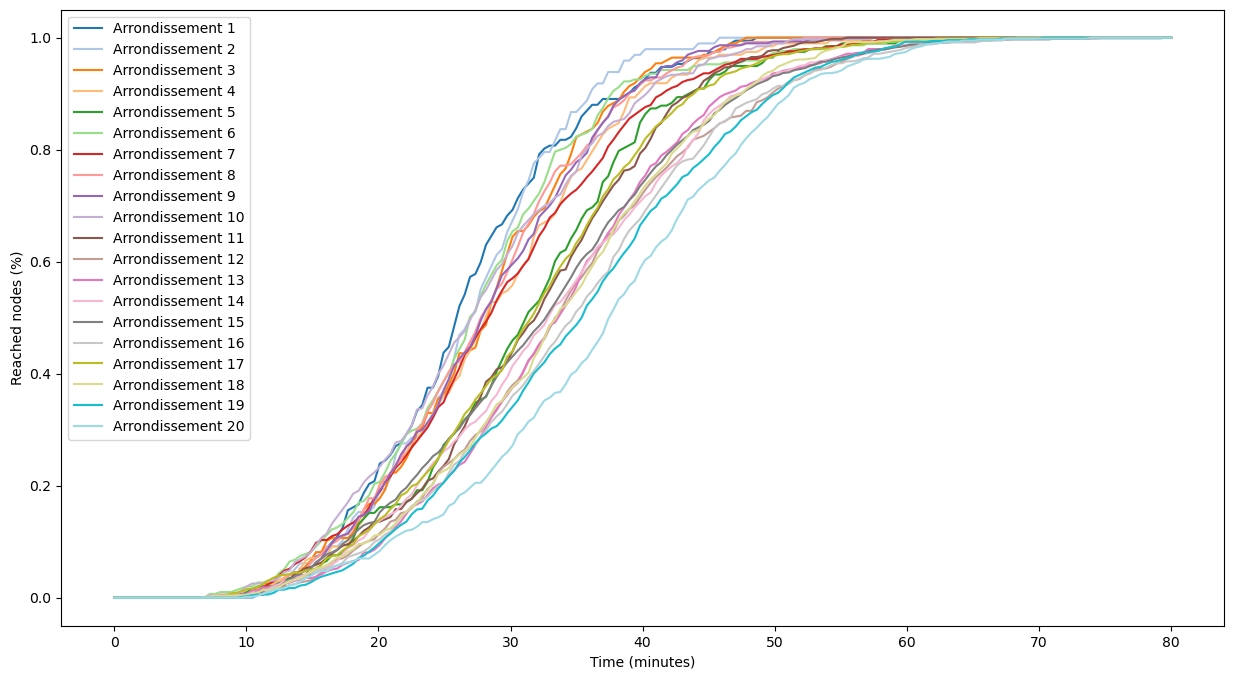

In [86]:
plt.figure(figsize=(15,8))
for arr in range(nodes.shape[0]):
    plt.plot(time_steps, nodes[arr], label=f'Arrondissement {arr+1}', color = color_palette(arr))

plt.xlabel('Time (minutes)')
plt.ylabel('Reached nodes (%)')
plt.legend()

plt.savefig('../static_maps_data/reached_nodes.png', dpi=300)
plt.show()

In [87]:
def calculate_area(dom_t, acc_city):
    acc_city_b = acc_city[:-1] 
    acc_city_B = acc_city[1:]   
    h = np.diff(dom_t)  

    A = np.sum((acc_city_b + acc_city_B) * h / 2)  

    norm = dom_t[-1]  
    Area = A / norm

    return Area

In [88]:
arrondissements_areas = []
arrondissement_names = []
for arr in range(nodes.shape[0]):
    area = calculate_area(time_steps, nodes[arr])
    arrondissements_areas.append(area)
    arrondissement_names.append(arr+1)
    

In [89]:
df_areas = pd.DataFrame({'Arrondissement': arrondissement_names, 'Area': arrondissements_areas})

In [91]:
df_areas.sort_values('Area', ascending=False).to_csv('../static_maps_data/arrondissements_areas.csv', index=False)